In [2]:
# load some libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate
from scipy.special import sph_harm
from scipy.special import erf
# import library for hf routines
import hf_routines as hf
# import library for setting up plots
import plotting as myplt

In [3]:
# set STO-3G basis and atoms
zeta = [1.24,1.24]
R = np.empty((2,3),dtype=float)
R[0,0] = R[0,1] = R[0,2] = 0.0
R[1,0] = 1.4
R[1,1] = R[1,2] = 0.0
Z = [1.0,1.0]
basis_set = [hf.sto(3,zeta[i],R[i,:]) for i in range(2)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(2)]

In [4]:
# compute matrices and twoE that are not dependent on coefficients
S, Sinv = hf.overlap(basis_set)
T = hf.kinetic(basis_set)
V = hf.core_potential(basis_set,atoms)
Hcore = V + T
twoE = hf.compute_twoE(basis_set)
# compute basis set orthogonalization transformation matrix
X = hf.orthogonalize_basis(S)

In [5]:
# use Hcore as the guess for the Fock matrix
HcoreX = np.dot(np.dot(X.T,Hcore),X)
e, C = np.linalg.eig(HcoreX)
# project C back into original basis
C = np.dot(X,C)

In [6]:
# setup some SCF routines
previousE = 0.0
deltaE = 1.0
thresh = 0.0001
iteration = 0 
while deltaE > thresh and iteration < 20:
    P = hf.constructDensityMat(C)
    G = hf.compute_G(P,twoE)
    F = Hcore + G
    energy, C, orbitalEnergies = hf.total_energy(F,X,Hcore,P,atoms)
    deltaE = abs(energy-previousE)
    previousE = energy
    iteration += 1
    print iteration, energy, deltaE

1 -1.1167152686375936 1.1167152686375936
2 -1.1167152686375936 0.0


In [7]:
print(C)

[[ 0.54893391  1.2114655 ]
 [ 0.54893391 -1.2114655 ]]


## Configuration Interaction
We have now performed the HF routine for H$_2$ in a minimal basis.  This gives us a ground state energy in the single determinant picture and two HF orbitals (occupied and unoccupied).  The configuration interaction (CI) approach defines a multideterminant wavefunction in terms of these HF orbitals.  The CI wavefunction can be defined as

$\Phi_{CI} = c_0 \psi_0 + c_1 \psi_1 + c_2 \psi_2 ...$

where $c_i$ are linear variational coefficients of the $\psi_i$ determinant.  These determinants can be thought of as different electronic populations of the HF orbitals.  In order for this summation to be valid, all $\psi_i$s must have the same electronic spin and overall symmetry.  It turns out that this restriction leads to only two possible determinants: the HF ground state and the doubly excited state:

$\Phi_{CI}^{H_2-min basis} = c_0 \psi_0 + c_1 \psi_D $.

We can solve for the energies and linear coefficients using the variational approach.  Since $\psi_i$s are HF orbitals, they are orthonormal implying that the overlap matrix $\mathbf{S}$ is simply the identity matrix.  Thus we need only diagonalize the $2\times2$ Hamiltonian matrix

$\mathbf{H} = \begin{bmatrix} \langle\psi_0|H|\psi_0\rangle & \langle\psi_0|H|\psi_D\rangle \\ \langle\psi_D|H|\psi_0\rangle & \langle\psi_D|H|\psi_D\rangle \end{bmatrix}$

where $\langle\psi_0|H|\psi_0\rangle = E_0$ is simply the HF ground-state energy, $\langle\psi_0|H|\psi_D\rangle = K_{12}$ is the exchange energy between the two HF orbitals, and $\langle\psi_D|H|\psi_D\rangle = 2h_{22} +J_{22}$ is the energy of the doubly occupied $\sigma^*$ orbital of the HF solution in the minimal basis.

For coding purposes it will be useful to define the ground-state and doubly excited state energies in terms of orbital energies and two-electron integrals:

$ E_0 = 2h_{11} + J_{11} = 2\epsilon_1 - J_{11}$

where $\epsilon_1 = h_{11} + J_{11}$ is the energy of the first orbital (lowest eigenvalue of the Fock matrix) and 

$\langle\psi_D|H|\psi_D\rangle = 2h_{22} +J_{22} = 2\epsilon_2-4J_{12}+J_{22} + 2K_{12}$

where $\epsilon_2 = h_{22} + 2J_{12}-K_{12}$ is the energy of the second orbital

In [8]:
hf_twoE = hf.update_twoE(C,twoE)
print "J11=", hf_twoE[0,0,0,0], "J11 in AOs:", twoE[0,0,0,0]
print "J12=", hf_twoE[0,0,1,1]
print "J22=", hf_twoE[1,1,1,1]
print "K12=", hf_twoE[0,1,1,0]

J11= 0.6745955469249243 J11 in AOs: 0.7746083600328787
J12= 0.6635673122491406
J22= 0.697500851571977
K12= 0.18125879964065408


In [9]:
# generate our CI Hamiltonian matrix
HCI = np.empty((2,2),dtype=float)
HCI[0,0] = energy # this is wrong because it includes nuclear repulsion
HCI[0,0] = 2*orbitalEnergies[0] - hf_twoE[0,0,0,0] # 2*e1 - J11
HCI[0,1] = HCI[1,0] = hf_twoE[0,1,1,0]
HCI[1,1] = 2*orbitalEnergies[1] - 4*hf_twoE[0,0,1,1] + hf_twoE[1,1,1,1] + 2*hf_twoE[0,1,1,0]

eCI, CI = np.linalg.eig(HCI)
print eCI
print CI
print 'Ecorr', eCI[0] - (2*orbitalEnergies[0] - hf_twoE[0,0,0,0])

[-1.85156278 -0.23314695]
[[-0.99362725 -0.11271598]
 [ 0.11271598 -0.99362725]]
Ecorr -0.02056179830757543


In [10]:
r = np.arange(0.5,10,0.05)
n = r.size
ci_energy = np.empty(r.size)
hf_energy = np.empty(r.size)
ci_gs_coeffs = np.empty((r.size,2))

In [11]:
for i in range(n):
    atoms[1].pos[0] = r[i]
    basis_set[1].R[0] = r[i]
    # compute matrices and twoE that are not dependent on coefficients
    S, Sinv = hf.overlap(basis_set)
    T = hf.kinetic(basis_set)
    V = hf.core_potential(basis_set,atoms)
    Hcore = V + T
    twoE = hf.compute_twoE(basis_set)
    # compute basis set orthogonalization transformation matrix
    X = hf.orthogonalize_basis(S)
    # given minimal basis and symmetry can analytically determine C
    C = hf.optimal_C(S)
    P = hf.constructDensityMat(C)
    G = hf.compute_G(P,twoE)
    F = Hcore + G
    hf_energy[i], C, orbitalEnergies = hf.total_energy(F,X,Hcore,P,atoms)
    # perform CI
    # get twoE in MOs
    hf_twoE = hf.update_twoE(C,twoE)
    # generate our CI Hamiltonian matrix
    HCI[0,0] = 2*orbitalEnergies[0] - hf_twoE[0,0,0,0] # 2*e1 - J11
    HCI[0,1] = HCI[1,0] = hf_twoE[0,1,1,0]
    HCI[1,1] = 2*orbitalEnergies[1] - 4*hf_twoE[0,0,1,1] + hf_twoE[1,1,1,1] + 2*hf_twoE[0,1,1,0]
    eCI, CI = np.linalg.eig(HCI)
    ci_energy[i] = np.amin(eCI)

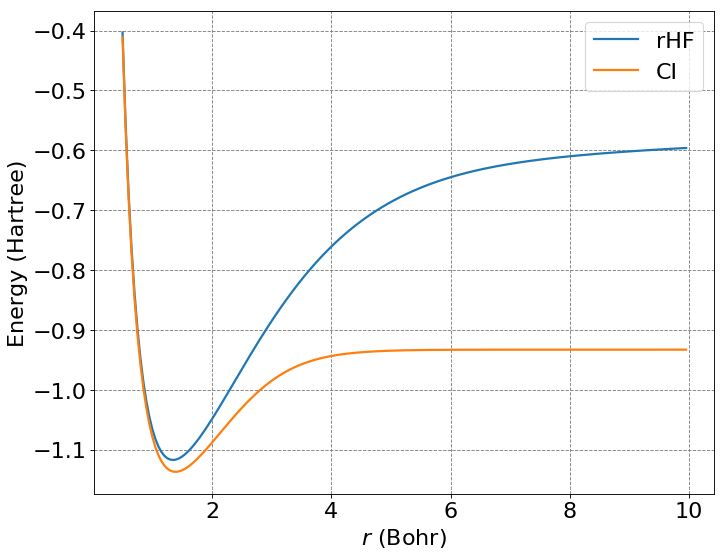

In [14]:
# plot results
ax = myplt.define_figure(xlabel="$r$ (Bohr)",ylabel="Energy (Hartree)")
ax.plot(r,hf_energy,lw=2,label='rHF')
ax.plot(r,ci_energy+1.0/r,lw=2,label='CI')
ax.legend(fontsize=20)

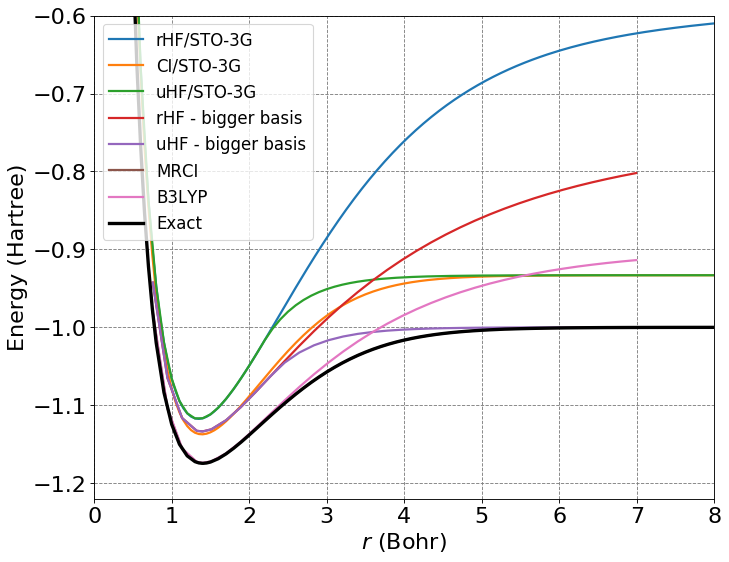

In [16]:
# plot results with other methods
# load data for other methods from files 
uhf = np.loadtxt("uhf_energy_scan.txt")
others = np.loadtxt("h2_various_methods.txt",skiprows=1)  # has a header line
exact = np.loadtxt("h2_kolos_wolniewicz.txt",skiprows=1)  # has a header line
# initialize figure using my plotting routine 
ax = myplt.define_figure(xlabel="$r$ (Bohr)",ylabel="Energy (Hartree)")
# minimal basis results
ax.plot(r,hf_energy,lw=2,label='rHF/STO-3G')
ax.plot(r,ci_energy+1.0/r,lw=2,label='CI/STO-3G')
ax.plot(uhf[:,0],uhf[:,1],lw=2,label='uHF/STO-3G')
# plot various other results
ax.plot(others[:,0]*1.88973,others[:,1],lw=2,label='rHF - bigger basis')  # r is in units of Angstroms
ax.plot(others[:,0]*1.88973,others[:,2],lw=2,label='uHF - bigger basis')  # r is in units of Angstroms
ax.plot(others[:,0]*1.88973,others[:,6],lw=2,label='MRCI')                # r is in units of Angstroms
ax.plot(others[:,0]*1.88973,others[:,7],lw=2,label='B3LYP')               # r is in units of Angstroms
ax.plot(exact[:,0],exact[:,1],lw=3,c='k',label='Exact')                   # The Kolos Wolniewicz "exact" results
# change x and y dimensions of plot to focus more on well
ax.set_ylim([-1.22,-0.6])
ax.set_xlim([0,8])
# make a legend
ax.legend(fontsize=15)